In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('feb_134_data.csv')
df.head()
len(df)

134

In [3]:
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
values = df.values
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_cols = df[cols]
df_base = df[['close', 'high', 'low','open']]
df_google = df[['close', 'high', 'low','open','google_trends_btc']]

In [5]:
# import dataframe_image as dfi
# desc = df_r
# dfi.export(desc, 'results.png')

In [6]:
# df_r = pd.DataFrame({'Units':[5,5], 'Batch Size': [6,6], 'Epochs':[37,29]}, index=['Base model', 'Base model w/ google trends'])

In [7]:
# import dataframe_image as dfi
# dfi.export(df_r, 'parameters.png')

In [8]:
round((len(df)) *0.75)

100

In [11]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt

n_hours = 5 #adding 5 hours lags creating number of observations 
#n_features = 5 #Features in the dataset.
data = pd.read_csv('feb_134_data.csv')

def model_run(df,n_hours,data):
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df.values)
    n_features = len(df.columns)
    n_train_hours =round((len(df)) *0.75)
    n_obs = n_hours* n_features
    reframed = series_to_supervised(scaled, n_hours, 1)
    index_val =  n_features-1 
    values = reframed.values
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    
    # split into input and outputs
    train_X, train_y = train[:, :n_obs], train[:, -1*(n_features)]
    test_X, test_y = test[:, :n_obs], test[:, -1*(n_features)]
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
    
    
    #model
    tf.random.set_seed(1)
    model = Sequential()
    model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    #%%time
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=1, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)
    mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    tb = TensorBoard('logs')


    # fit network
    history = model.fit(train_X, train_y, epochs=100, batch_size=6,callbacks=[es, rlr, mcp, tb],validation_data=(test_X, test_y), verbose=2, shuffle=False,validation_split=0.2)
    #plot history

        # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_hours* n_features,))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -1*(index_val):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -1*(index_val):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    r2 = r2_score(inv_y, inv_yhat)
    print('Test R2: %.3f' % r2)
    
    #Training and Validation Loss 
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title('Training and Validation Loss', family='Arial', fontsize=12)
    plt.xlabel('# Epochs ', family='Arial', fontsize=10)
    plt.ylabel('Loss', family='Arial', fontsize=10)
    plt.xticks(rotation=45, fontsize=8)
    plt.legend()
    plt.show()
    
    #Predicted vs Actual Plot
    x = pd.DataFrame(data['date'].tail(test_y.shape[0]-1))
    fig,ax = plt.subplots(figsize=(10, 5))
    ax.plot((data['date'].tail((test_y.shape[0]))),inv_y,label='Real')
    ax.plot((data['date'].tail((test_y.shape[0]))),inv_yhat,label='Predicted')
    ax.set_xticks((data['date'].tail((test_y.shape[0]))[::2]))
    ax.set_xticklabels((data['date'].tail((test_y.shape[0])))[::2],rotation=45)
    ax.set_title("Predicted and Actual Bitcoin Close Prices")
    ax.set_xlabel('Timeline', )
    ax.set_ylabel('Bitcoin Close Prices')
    ax.legend()
    plt.show()

    return history,rmse,r2


### Base model 

Epoch 1/100
14/14 - 2s - loss: 0.1864 - val_loss: 0.7473

Epoch 00001: val_loss improved from inf to 0.74728, saving model to weights.h5
Epoch 2/100
14/14 - 0s - loss: 0.1475 - val_loss: 0.6705

Epoch 00002: val_loss improved from 0.74728 to 0.67050, saving model to weights.h5
Epoch 3/100
14/14 - 0s - loss: 0.1159 - val_loss: 0.5967

Epoch 00003: val_loss improved from 0.67050 to 0.59667, saving model to weights.h5
Epoch 4/100
14/14 - 0s - loss: 0.0935 - val_loss: 0.5255

Epoch 00004: val_loss improved from 0.59667 to 0.52552, saving model to weights.h5
Epoch 5/100
14/14 - 0s - loss: 0.0825 - val_loss: 0.4640

Epoch 00005: val_loss improved from 0.52552 to 0.46396, saving model to weights.h5
Epoch 6/100
14/14 - 0s - loss: 0.0770 - val_loss: 0.4137

Epoch 00006: val_loss improved from 0.46396 to 0.41369, saving model to weights.h5
Epoch 7/100
14/14 - 0s - loss: 0.0741 - val_loss: 0.3763

Epoch 00007: val_loss improved from 0.41369 to 0.37630, saving model to weights.h5
Epoch 8/100
14/14

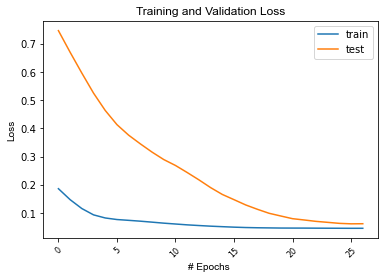

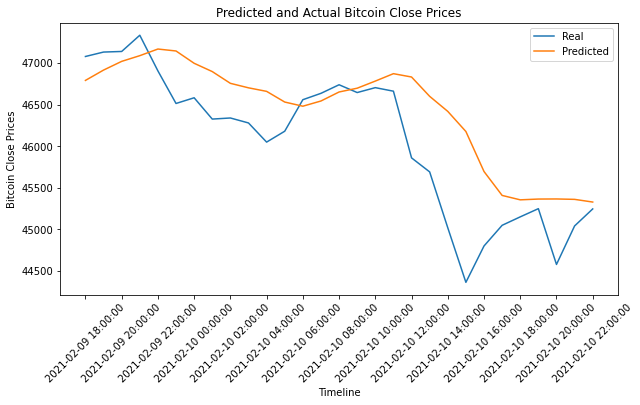

(<tensorflow.python.keras.callbacks.History at 0x7f813990c040>,
 610.9447476662533,
 0.4762370637140455)

In [12]:
model_run(df_base,n_hours,data)

### Base model with google trends

Epoch 1/100
14/14 - 2s - loss: 0.2030 - val_loss: 0.8188

Epoch 00001: val_loss improved from inf to 0.81884, saving model to weights.h5
Epoch 2/100
14/14 - 0s - loss: 0.1638 - val_loss: 0.7410

Epoch 00002: val_loss improved from 0.81884 to 0.74101, saving model to weights.h5
Epoch 3/100
14/14 - 0s - loss: 0.1289 - val_loss: 0.6579

Epoch 00003: val_loss improved from 0.74101 to 0.65791, saving model to weights.h5
Epoch 4/100
14/14 - 0s - loss: 0.1031 - val_loss: 0.5704

Epoch 00004: val_loss improved from 0.65791 to 0.57045, saving model to weights.h5
Epoch 5/100
14/14 - 0s - loss: 0.0887 - val_loss: 0.4899

Epoch 00005: val_loss improved from 0.57045 to 0.48989, saving model to weights.h5
Epoch 6/100
14/14 - 0s - loss: 0.0819 - val_loss: 0.4232

Epoch 00006: val_loss improved from 0.48989 to 0.42322, saving model to weights.h5
Epoch 7/100
14/14 - 0s - loss: 0.0781 - val_loss: 0.3731

Epoch 00007: val_loss improved from 0.42322 to 0.37309, saving model to weights.h5
Epoch 8/100
14/14

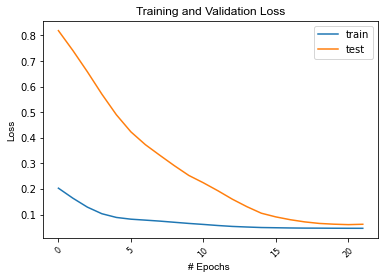

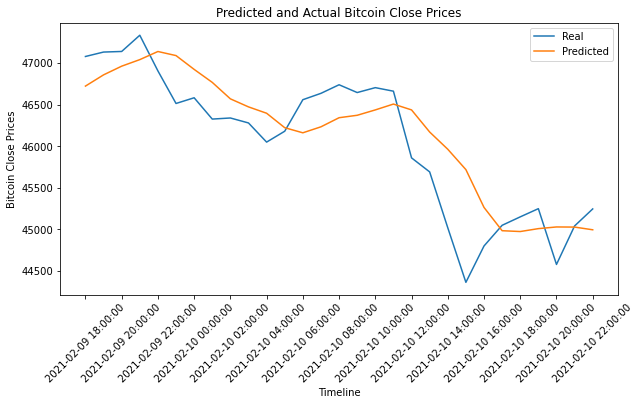

(<tensorflow.python.keras.callbacks.History at 0x7f811d9a8130>,
 444.9180461534933,
 0.722226421129814)

In [13]:
model_run(df_google,n_hours,data)